In [1]:
import sys
sys.path.append('D:/Master/Blok3/AAS/')

In [442]:
import numpy as np
from toolbox import vis
from toolbox import as_toolbox as ast
import os
import importlib
from iminuit import Minuit
from toolbox.ExternalFunctions import Chi2Regression
import matplotlib.pyplot as plt
import pandas as pd
import numpy_indexed as npi
from scipy import stats

# Strong scaling 

In [443]:
#data is stored as num_thread, time, model_size, parallel
Data = pd.read_csv('df.csv')
zero_mask = Data['checksum']==0
Data = Data[~zero_mask]
#set number of threads to one where it is zero
zero_threads_mask = Data['Nthreads']==0
Data = Data[~zero_threads_mask]
outlier_mask = Data['Ttotal']>100
Data = Data[~outlier_mask]
#Data_outlier = Data[outlier_mask]
Data.head(2)

,Nvox,Nprocs,Nthreads,Nnodes,Ttotal,Tread,Tcomp,Twrite,checksum,Par
0,4.0,1.0,1.0,1.0,0.076408,0.064402,0.000914,1.300000e-07,1.53523,0.0
1,4.0,1.0,1.0,1.0,0.083226,0.070426,0.000692,1.700000e-07,1.53523,0.0


In [444]:
par_mask = Data['Par']==1
Data_par = Data[par_mask]
Data_seq = Data[~par_mask]
strong_mask = Data_par.iloc[:,0]==256
Data_s = Data_par[strong_mask]

#Data_ws = Data[~mask_strong_scaling]
#Data_ss = Data_ss[np.argsort(Data_ss[:, 0])]
Data_s.head(4)

,Nvox,Nprocs,Nthreads,Nnodes,Ttotal,Tread,Tcomp,Twrite,checksum,Par
25,256.0,1.0,1.0,1.0,66.48710,6.11382,60.329400,0.008531,353993.0,1.0
29,256.0,4.0,64.0,4.0,8.09776,7.04157,0.852418,0.149217,353993.0,1.0
30,256.0,4.0,64.0,4.0,4.81181,3.79936,0.806541,0.144883,353993.0,1.0
31,256.0,2.0,1.0,1.0,57.13700,4.51749,52.537800,0.027175,353993.0,1.0


# Strong Scaling

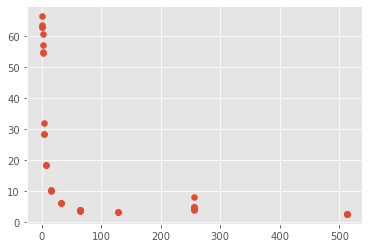

In [445]:
plt.scatter(X_s, Y_s)

29    8.09776
30    4.81181
41    4.80182
45    4.21124
64    4.10069
72    4.19746
84    5.01245
93    4.91570
Name: Ttotal, dtype: float64


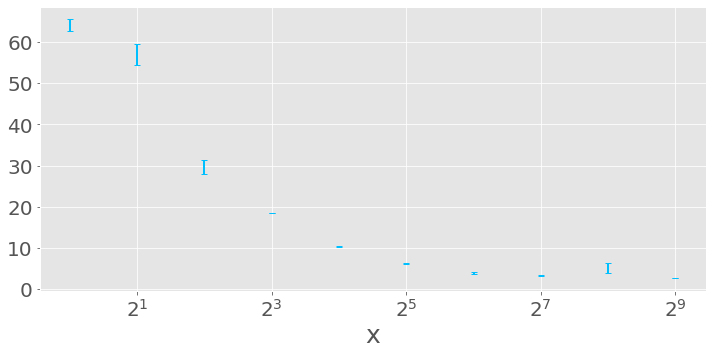

In [446]:
X_s = Data_s['Nprocs']*Data_s['Nthreads']
Y_s = Data_s['Ttotal']
X1mask = X_s == int(2**8)
#mask_strange = np.isclose(Y_s, 8.09776)
#X_s = X_s[~mask_strange]
#Y_s = Y_s[~mask_strange]
print(Y_s[X1mask])
x_unique_s, y_mean_s = npi.group_by(X_s).mean(Y_s)
_, y_std_s = npi.group_by(X_s).std(Y_s)
fig, ax = vis.nice_plot(
    x_unique_s, y_mean_s, SY = y_std_s, scatter=True, 
    show_plot=False, err_markersize=.1, errorbar = True, capthick=1,
elinewidth=2.,)
ax.set_xscale('log', base=2)
#ax.set_yscale('log')
fig

In [447]:
def amdahl(num_cores, p): return 1/((1-p) + p/num_cores)

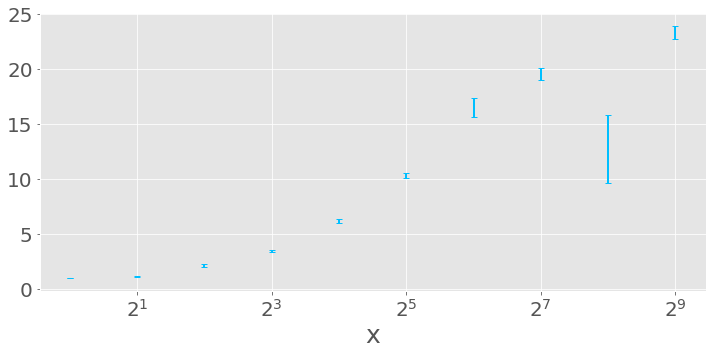

In [448]:
speedup_s = y_mean_s[0]/y_mean_s
speedup_s_err = np.sqrt((y_std_s[0]/y_mean_s)**2 
                        + (y_std_s*y_mean_s[0]/y_mean_s**2)**2)
fig, ax = vis.nice_plot(
    x_unique_s, speedup_s, SY = speedup_s_err, scatter=True, 
    show_plot=False, err_markersize=.1, errorbar = True, capthick=1,
elinewidth=2.)
ax.set_xscale('log', base=2)
#ax.set_yscale('log')
fig

In [449]:
threshold_exp = 9
threshold_s = int(2**threshold_exp)
mask_fit_s = x_unique_s<=threshold_s
f_chi2_s = Chi2Regression(
    amdahl, x_unique_s[mask_fit_s], speedup_s[mask_fit_s], 
    sy = speedup_s_err[mask_fit_s] )
minuit_s = Minuit(f_chi2_s, p = .99, pedantic = False)
minuit_s.migrad()
ps = minuit_s.values['p']
pss = minuit_s.errors['p']
ndofs = len(x_unique_s[mask_fit_s])-1
chi2_s = minuit_s.fval
pval_s = stats.chi2.sf(chi2_s, ndofs)
print(pval_s), chi2_s

1.2851825035110615e-278


(None, 1320.2858474219843)

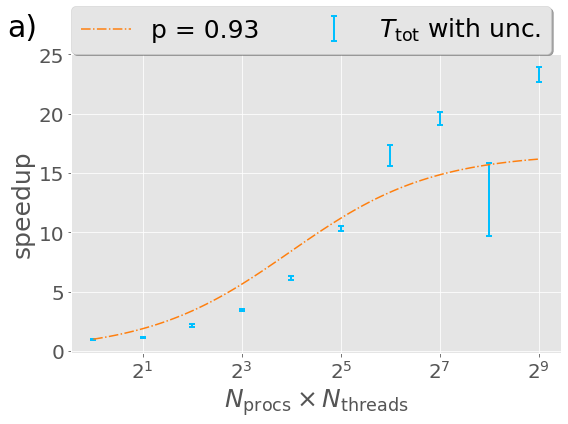

In [476]:
colors = vis.Color_palette(0)
xaxis = np.logspace(0,threshold_exp,100, base = 2)
fig, ax = vis.nice_plot(
    x_unique_s, speedup_s, SY = speedup_s_err,  
    err_markersize=.1, errorbar = True, capthick=2,
    elinewidth=2.,figsize = (8,6),
    scatter=True, scr_markersize=50, legend_loc=4, 
    data_label=r'$T_{\rm tot}$'+' with unc.', show_plot = False,
    color = colors[0])
fig, ax = vis.nice_plot(
    xaxis, amdahl(xaxis,.94),
    data_label='p = '+ '{:3.2f}'.format(ps), show_plot = False, 
    axis = ax, figure=fig, linewidth=1.5, ylabel='speedup',  
    color = (0,1), linestyle='-.',
    xlabel=r'$N_{\rm procs}\times N_{\rm threads} $')

ax.legend(loc = (0.,1), ncol = 2, fontsize = 25, shadow = True)
ax.set_xscale('log', base=2)
ax.text(.3,26.5,'a)', fontsize = 30)
fig.tight_layout()
fig.savefig('strong_scaling.pdf', dpi = 80)
fig

# Weak Scaling 

In [451]:
def gustafson(num_cores, p): return num_cores + (1 - num_cores)*(1-p)

In [452]:
weak_mask0 = (Data_par['Nthreads']==1) & (Data_par['Nprocs']==1) & (Data_par['Nvox']==64)
weak_mask1 = (Data_par['Nthreads']==4) & (Data_par['Nprocs']==2) & (Data_par['Nvox']==128)
weak_mask2 = (Data_par['Nthreads']==32) & (Data_par['Nprocs']==2)& (Data_par['Nvox']==256)
weak_mask3 = (Data_par['Nthreads']==64) & (Data_par['Nprocs']==8)& (Data_par['Nvox']==512)
weak_mask = weak_mask0 | weak_mask1 | weak_mask2 | weak_mask3
Data_w = Data_par[weak_mask]
Data_w#.head(3)

,Nvox,Nprocs,Nthreads,Nnodes,Ttotal,Tread,Tcomp,Twrite,checksum,Par
26,128.0,2.0,4.0,1.0,3.80006,1.60561,2.15173,0.004962,44248.7,1.0
27,64.0,1.0,1.0,1.0,8.78127,6.53987,2.19569,0.000004,7789.4,1.0
28,128.0,2.0,4.0,1.0,4.10571,1.86541,2.19493,0.000006,44248.7,1.0
36,512.0,8.0,64.0,8.0,7.44898,3.80874,2.24142,0.000005,2832060.0,1.0
49,256.0,2.0,32.0,1.0,3.97522,1.63946,2.25447,0.000009,353993.0,1.0
52,64.0,1.0,1.0,1.0,8.75564,6.37257,2.34813,0.000187,7789.4,1.0
69,256.0,2.0,32.0,1.0,3.54885,1.40193,2.05782,0.000009,353993.0,1.0
76,256.0,2.0,32.0,1.0,3.88749,1.58828,2.21343,0.027861,353993.0,1.0
78,128.0,2.0,4.0,1.0,4.05434,1.92633,2.08640,0.000010,44248.7,1.0
80,64.0,1.0,1.0,1.0,8.73669,6.38256,2.31067,0.000179,7789.4,1.0


In [453]:
X_w = Data_w['Nprocs']*Data_w['Nthreads']
Y_w = Data_w['Ttotal']
x_unique_w, y_mean_w = npi.group_by(X_w).mean(Y_w)
_, y_std_w = npi.group_by(X_w).std(Y_w)
X1mask = X_w == 128
print(Y_w[X1mask])

Series([], Name: Ttotal, dtype: float64)


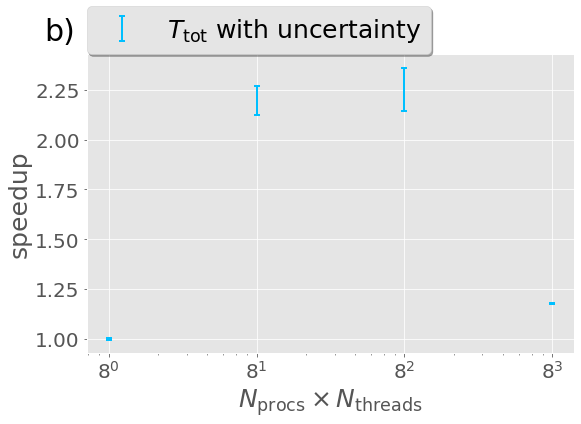

In [471]:
speedup_w = y_mean_w[0]/y_mean_w
speedup_w_err = np.sqrt((y_std_w[0]/y_mean_w)**2 
                        + (y_std_w*y_mean_w[0]/y_mean_w**2)**2)
fig, ax = vis.nice_plot(
    x_unique_w, speedup_w, SY = speedup_w_err, scatter=True, 
    show_plot=False, err_markersize=.1, errorbar = True, capthick=2,
    elinewidth=2., data_label=r'$T_{\rm tot}$'+' with uncertainty', figsize = (8,6),
    xlabel=r'$N_{\rm procs}\times N_{\rm threads} $', ylabel='speedup')

ax.legend(loc = (0,1), ncol = 3, fontsize = 25, shadow = True)
ax.set_xscale('log', base=8)
ax.text(0.4,2.5,'b)', fontsize = 30)
fig.tight_layout()
fig.savefig('weak_scaling.pdf', dpi = 80)
fig

In [455]:
#f_chi2_w = Chi2Regression(gustafson,x_unique_w, speedup_w, sy = speedup_w_err  )
#minuit_w = Minuit(f_chi2_w, p = .8, pedantic = False)
#minuit_w.migrad()
#pw = minuit_w.values['p']

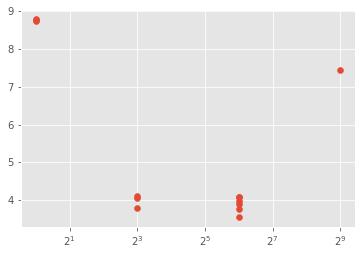

In [456]:
plt.scatter(X_w, Y_w)
plt.xscale('log', base = 2)

# Absolute times 

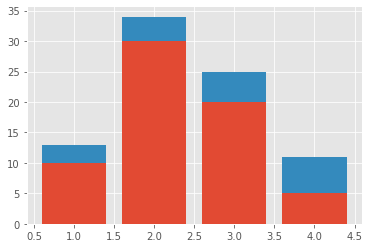

In [99]:
plt.bar([1,2,3,4], [10,30,20,5])
plt.bar([1,2,3,4], [3,4,5,6], bottom = [10,30,20,5])
plt.show()

In [457]:
Data_seq

,Nvox,Nprocs,Nthreads,Nnodes,Ttotal,Tread,Tcomp,Twrite,checksum,Par
0,4.0,1.0,1.0,1.0,0.076408,0.064402,0.000914,1.300000e-07,1.53523,0.0
1,4.0,1.0,1.0,1.0,0.083226,0.070426,0.000692,1.700000e-07,1.53523,0.0
2,64.0,1.0,1.0,1.0,1.055590,0.040182,1.005250,7.000000e-08,7789.40000,0.0
3,256.0,1.0,1.0,1.0,59.758100,0.140864,59.572400,7.240000e-06,353993.00000,0.0
5,64.0,1.0,1.0,1.0,1.109470,0.060367,1.038580,1.600000e-07,7789.40000,0.0
7,32.0,1.0,1.0,1.0,0.217659,0.045143,0.162436,6.000000e-08,975.99400,0.0
8,8.0,1.0,1.0,1.0,0.071261,0.056366,0.004339,1.500000e-07,14.71000,0.0
9,8.0,1.0,1.0,1.0,0.082438,0.064980,0.004303,1.500000e-07,14.71000,0.0
10,128.0,1.0,1.0,1.0,7.514090,0.059410,7.441740,4.220000e-06,44248.70000,0.0
11,4.0,1.0,1.0,1.0,0.363329,0.348291,0.000794,3.200000e-07,1.53523,0.0


In [477]:
seq_mask_128 = Data_seq['Nvox']==256
Data_seq_plot = Data_seq[seq_mask_128]
par_mask_128 = Data_par['Nvox']==256
Data_par_plot = Data_par[par_mask_128]
Xp = Data_par_plot['Nprocs']*Data_par_plot['Nthreads']
Yp_tot = Data_par_plot['Ttotal']
Yp_w = Data_par_plot['Twrite']
Yp_r = Data_par_plot['Tread']
Yp_c = Data_par_plot['Tcomp']
Ys_tot = Data_seq_plot['Ttotal']
Ys_w = Data_seq_plot['Twrite']
Ys_r = Data_seq_plot['Tread']
Ys_c = Data_seq_plot['Tcomp']

Xp_unq, Yp_mean_tot = npi.group_by(Xp).mean(Yp_tot)
Xp_unq_r, Yp_mean_r = npi.group_by(Xp).mean(Yp_r)
_, Yp_mean_w = npi.group_by(Xp).mean(Yp_w)
_, Yp_mean_c = npi.group_by(Xp).mean(Yp_c)

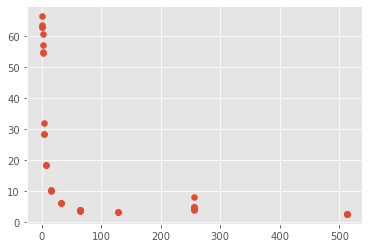

In [459]:
plt.scatter(Xp, Yp_tot)

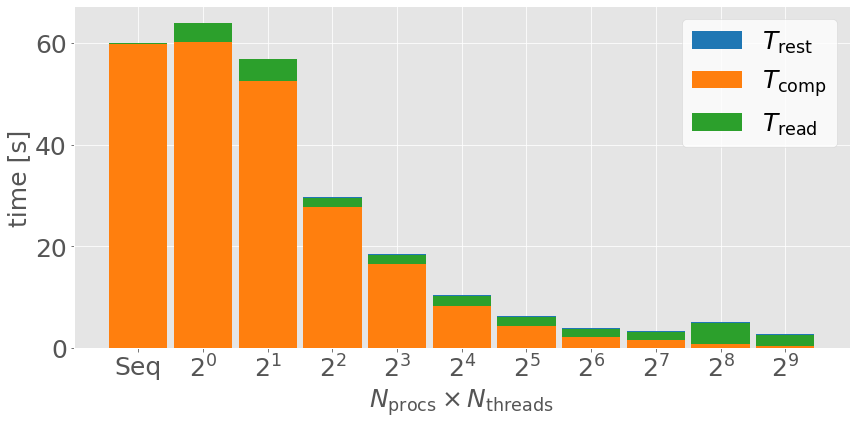

In [460]:
fig, ax = plt.subplots(1,figsize = (12,6))
labels = ['Seq', r'$2^{0}$',r'$2^{1}$',r'$2^{2}$',
          r'$2^{3}$', r'$2^{4}$',r'$2^{5}$',r'$2^{6}$',
          r'$2^{7}$',r'$2^{8}$', r'$2^{9}$']
#sequential
colors = vis.Color_palette(0)
ax.bar(0, Ys_tot ,.9, label = r'$T_{\rm rest}$', color = colors[0])
ax.bar(0, Ys_c ,.9, label = r'$T_{\rm comp}$', color = colors[1])
ax.bar(0, Ys_r ,.9, label = r'$T_{\rm read}$', bottom = Ys_c, color = colors[2])


ax.bar(np.arange(1,len(Yp_mean_tot)+1), 
       Yp_mean_tot ,.9, color = colors[0])
ax.bar(np.arange(1,len(Yp_mean_c)+1), 
        Yp_mean_c ,.9,  color = colors[1])

ax.bar(np.arange(1,len(Yp_mean_r)+1), 
        Yp_mean_r ,.9,  color = colors[2],
      bottom = Yp_mean_c)


x = np.arange(11)  # the label locations
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 25)
ax.legend(loc = 0, ncol =1 , fontsize = 25,facecolor = 'white')
#ax.set_title('small world', fontsize = 25)
ax.set_ylabel('time [s]', fontsize = 25)
ax.set_xlabel(r'$N_{\rm procs}\times N_{\rm threads} $', fontsize = 25)
ax.tick_params(axis='both', which='major', labelsize=25)
#medium
#ax.set_yscale('log')
fig.tight_layout()
fig.savefig('time_abs.pdf', dpi = 80)

In [ ]:
def gustafson(num_cores, serial): return num_cores + (1 - num_cores)*serial

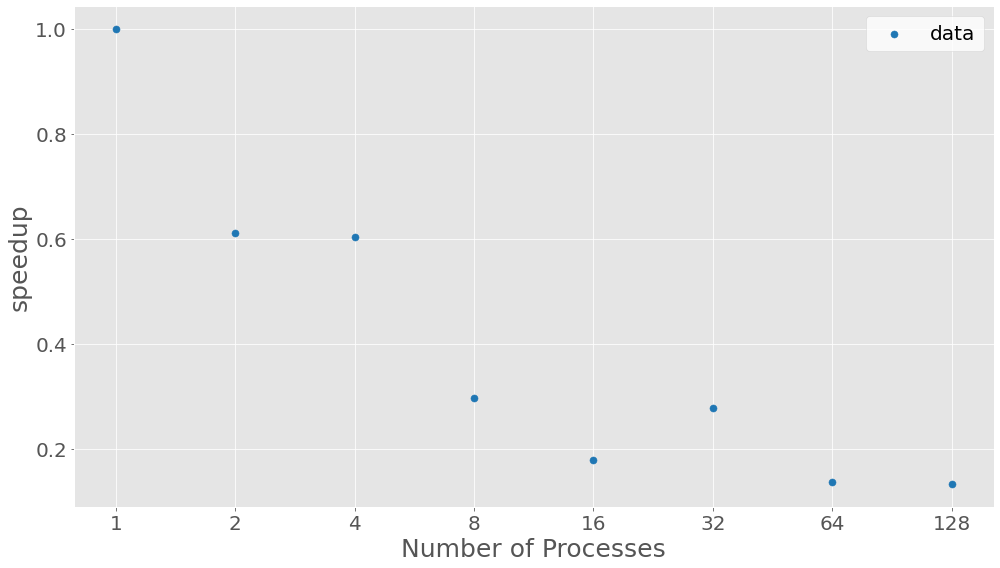

In [82]:
colors = vis.Color_palette(0)
xaxis = np.linspace(1,128,200)
Data_ws = Data_ws[np.argsort(Data_ws[:, 0])]
speedup_ws = Data_ws[1,1]/Data_ws[:,1]
serial = .99

fig, ax = vis.nice_plot(
    Data_ws[1:,0], speedup_ws[1:], figsize = (14,8),
    scatter=True, scr_markersize=50, legend_loc=4, 
    data_label=r'data', show_plot = False,
    color = colors[0])
#fig, ax = vis.nice_plot(
#    xaxis, gustafson(xaxis,serial),
#    data_label='parallel = '+ '{:3.2f}'.format(ps), show_plot = False, axis = ax, figure=fig,
#    linewidth=1.5, ylabel='speedup',  color = colors[0], linestyle='-.',
#    xlabel='Number of processes')
#ax.set_ylim(0.5,4.5)
ax.legend(loc = 0, ncol = 3, fontsize = 20,facecolor = 'white')
ax.set_xscale('log', base=2)
labels = [1,2,4,8,16,32,64,128]
x = labels  # the label locations
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 20)
ax.set_ylabel('speedup', fontsize = 25)
ax.set_xlabel('Number of Processes', fontsize = 25)
fig.tight_layout()
fig.savefig('weak_scaling.pdf', dpi = 80)
fig

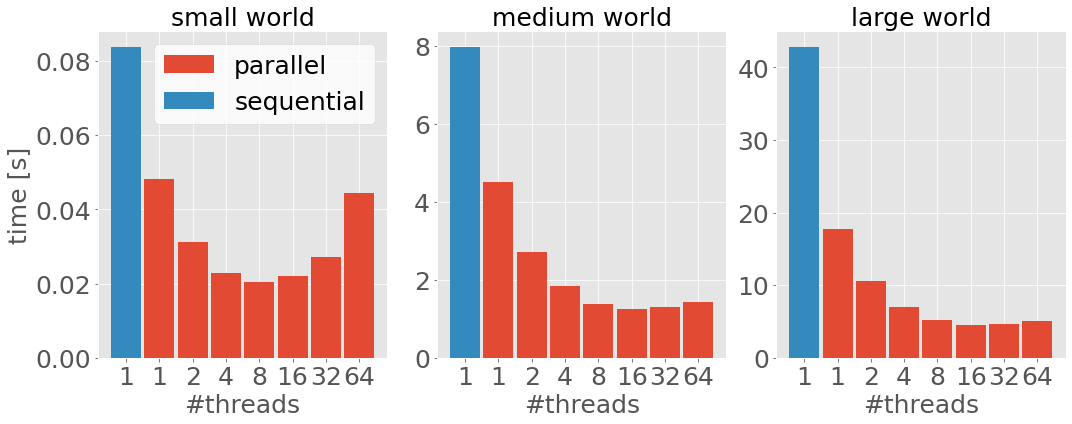

In [143]:
Data_s = Data_s[np.argsort(Data_s[:, 2])]#sort for worldsize
time_seq = Data_s[:,1]

#small world
Data_p_s = Data_p_s[np.argsort(Data_p_s[:, 0])]#sort for num_processors
time_p_s = Data_p_s[:,1]
#medium
Data_p_m = Data_p_m[np.argsort(Data_p_m[:, 0])]#sort for num_processors
time_p_m = Data_p_m[:,1]
#large
Data_p_l = Data_p_l[np.argsort(Data_p_l[:, 0])]#sort for num_processors
time_p_l = Data_p_l[:,1]

fig, ax = plt.subplots(1,3,figsize = (15,6))
#small
ax[0].bar(np.arange(1,8), time_p_s,.9, label = 'parallel')
ax[0].bar(0, time_seq[0],.9, label = 'sequential')
labels = [1, 1,2,4,8,16,32,64]
x = np.arange(8)  # the label locations
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize = 25)
ax[0].legend(loc = 0, ncol =1 , fontsize = 25,facecolor = 'white')
ax[0].set_title('small world', fontsize = 25)
ax[0].set_ylabel('time [s]', fontsize = 25)
ax[0].set_xlabel('#threads', fontsize = 25)
ax[0].tick_params(axis='both', which='major', labelsize=25)
#medium
ax[1].bar(np.arange(1,8), time_p_m,.9, label = 'parallel')
ax[1].bar(0, time_seq[1],.9, label = 'sequential')
labels = [1, 1,2,4,8,16,32,64]
x = np.arange(8)  # the label locations
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize = 25)
ax[1].set_title('medium world', fontsize = 25)
ax[1].tick_params(axis='both', which='major', labelsize=25)
ax[1].set_xlabel('#threads', fontsize = 25)
#large
ax[2].bar(np.arange(1,8), time_p_l,.9, label = 'parallel')
ax[2].bar(0, time_seq[2],.9, label = 'sequential')
labels = [1, 1,2,4,8,16,32,64]
x = np.arange(8)  # the label locations
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels, fontsize = 25)
ax[2].set_title('large world', fontsize = 25)
ax[2].tick_params(axis='both', which='major', labelsize=25)
ax[2].set_xlabel('#Nprocs', fontsize = 25)
fig.tight_layout()
fig.savefig('time_abs.pdf', dpi = 80)

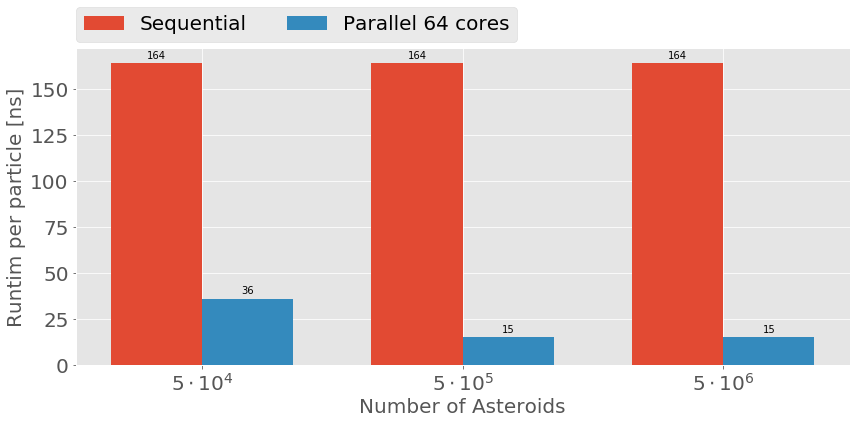

In [161]:
#choosing 24 processors for parallel computation
fig,ax = plt.subplots(figsize = (12,6))
plt.style.use('ggplot')
time_seq = np.array([164, 164, 164 ])
time_par = np.array([36, 15, 15])
labels = ['small', 'medium', 'large']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, time_seq, width, label='Sequential')
rects2 = ax.bar(x + width/2, time_par, width, label='Parallel 64 cores')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 20)
ax.legend(loc = (0,1.02), ncol =2 , fontsize = 20)
ax.set_xlabel('Size of the grid', fontsize = 20)
ax.set_ylabel('Runtime [s]', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
